# Computing the energy levels of NiH

This notebook will demonstrate how to use the **DiAtomic** library for computing the energy levels of the three lowest coupled electronic states of NiH molecule. It will also be shown how to use its functionality for analyzing the observed data and the results.

In [1]:
from diatomic import *
from math import sqrt as _sqrt

At the first line the ```MoleculeData``` object is defined. Then all neccessary properties are defined and attached to this object like the list containing the chemical symbols for all isotopes, the indices of the isotopes for which the energy levels to be computed, the range of rotational qunatum numbers, the reference J level and the parity labels.

In [24]:
mdata = MoleculeData()

mdata.molecule = ['58Ni1H', '60Ni1H', '62Ni1H']
mdata.nisotopes = [1, 2, 3]
mdata.jrange = (0.5, 16.5)
mdata.referencej = 2.5
mdata.parities = 0, 1

Then the function ```set_exp_data``` is called which accepts two parameters: the name of the file contating the experimental data and a list with markers (optional) for filttering the data.

In [25]:
mdata.set_exp_data('nih20nn_updated.dat', markers=[1, 15, 25])

In [4]:
! head -n 8 'nih20nn_updated.dat'

680
      1   0    2.5       0.000000     1    0.009    1    5
      2   0    3.5      53.827000     1    0.009    1    5
      3   0    4.5     122.962000     1    0.009    1    5
      4   0    5.5     207.353000     1    0.009    1    5
      5   0    6.5     306.937000     1    0.009    1    5
      6   0    7.5     421.632000     1    0.009    1    5
      7   0    8.5     551.357000     1    0.009    1    5


Initilize the Grid object providing the number of grid points, the range of internuclear distancies and the slover method.

In [26]:
grid = Grid(npoints=170, rgrid=(0.75,3.0), solver='sinc')

In [6]:
# this function will return the generated grid
rgrid = grid.get_grid_points()

Each channel is defined by creating a new object of type ```Channel```; the list of all channel objects is then passed to the function ```set_channel_parameters```

In [27]:
vpot = '0sigma_s.pot'
wpot = '0pi_s.pot'
xpot = '0delta_s.pot'
pmodel = 'cspline'

sigma = Channel(filep=vpot, model=pmodel, nlambda=0, sigma=0.5, multiplicity=2, rotc=0.0)
pi1 = Channel(filep=wpot, model=pmodel, nlambda=1, sigma=-0.5, multiplicity=2, rotc=0.0)
pi2 = Channel(filep=wpot, model=pmodel, nlambda=1, sigma=0.5, multiplicity=2, rotc=0.0)
delta1 = Channel(filep=xpot, model=pmodel, nlambda=2, sigma=-0.5, multiplicity=2, rotc=0.0)
delta2 = Channel(filep=xpot, model=pmodel, nlambda=2, sigma=0.5, multiplicity=2, rotc=0.0)

Channel.set_channel_parameters([sigma, pi1, pi2, delta1, delta2])

The structure of the potential files is the following:

In [8]:
%cat $vpot $wpot $xpot

18
      0.750000000000      57499.99936144024105      0
      0.890625000000      35999.99892848196760      0
      0.994565217400      23539.34668086847523      0
      1.116847826100      13499.81915722942176      1
      1.214673913000       7748.75668530742769      1
      1.288043478300       4619.05501345306493      1
      1.385869565200       2333.45000218718042      1
      1.508152173900       1613.74169884768821      1
      1.630434782600       2348.07620999990331      1
      1.752717391300       3940.17967621977641      1
      1.850543478300       5513.06766203513598      1
      1.972826087000       7730.17306792032105      1
      2.085937500000       9983.53095523668162      1
      2.226562500000      12772.81237592331308      1
      2.367187500000      15399.53569083805633      1
      2.507812500000      17459.12887562008109      0
      2.718750000000      19737.71266938960616      0
      3.000000000000      22070.00000082332190      0
18
      0.750000000000  

In [9]:
#%matplotlib notebook
Plotting.plot_potentials_points([vpot, wpot, xpot], ninter=40, xlim=(0.9,2.7), ylim=(-500,2.5e4), save=False)

Each coupling is defined by creating a new object of type ```Coupling```, the list of all coupling objects is then passed to the function ```set_coupling_parameters```

In [28]:
cmodel = 'cspline'

soww = Coupling(
    interact=((2,2), (3,3)), coupling=('spin-orbit', 'spin-orbit'),
    model=cmodel, multiplier=(-1.0,1.0), label='SO_WW'
)

soxx = Coupling(
    interact=((4,4), (5,5)), coupling=('spin-orbit', 'spin-orbit'),
    model=cmodel, multiplier=(-1.0,1.0), label='SO_XX'
)

sovw = Coupling(
    interact=(1,2), coupling='spin-orbit', model=cmodel,
    multiplier=1.0, label='SO_VW'
)

sowx = Coupling(
    interact=(3,4), coupling='spin-orbit', model=cmodel,
    multiplier=1.0, label='SO_WX'
)

sjxx = Coupling(
    interact=(4,5), coupling='SJ', model=cmodel,
    multiplier=1.0, label='SJ_X1X2'
)

sjww = Coupling(
    interact=(2,3), coupling='SJ', model=cmodel,
    multiplier=1.0, label='SJ_W1W2'
)

sjvv =  Coupling(
    interact=(1,1), coupling='SJ_parity', model=cmodel,
    multiplier=1.0, label='SJ_VV'
)

mwx = 2.0
ljwx = Coupling(
    interact=((2,4), (3,5), (3,4)), coupling=('LJ', 'LJ', 'SL'),
    model=cmodel, multiplier=(mwx,mwx,mwx), label='LJ_WX'
)

mvw = _sqrt(6.0)
ljvw = Coupling(
    interact=((1,3), (1,2), (1,2)), coupling=('LJ', 'LJ_parity', 'SL'),
    model=cmodel, multiplier=(mvw,mvw,mvw), label='LJ_VW'
)

ldv = Coupling(
    interact=(1,1), coupling='LambdaD', model=cmodel,
    multiplier=1.0, label='LD_V'
)

ldw2 = Coupling(
    interact=(2,2), coupling='LambdaD', model=cmodel,
    multiplier=1.0, label='LD_W2'
)

ldw1 = Coupling(
    interact=(3,3), coupling='LambdaD', model=cmodel,
    multiplier=1.0, label='LD_W1'
)

ldx1 = Coupling(
    interact=(4,4), coupling='LambdaD', model=cmodel,
    multiplier=1.0, label='LD_X1'
)

ldx2 = Coupling(
    interact=(5,5), coupling='LambdaD', model=cmodel,
    multiplier=1.0, label='LD_X2'
)

couplings = [
    soww, soxx, sovw, sowx, sjxx, sjww, sjvv, 
    ljvw, ljwx, ldv, ldw1, ldw2, ldx1, ldx2
]

Coupling.set_coupling_parameters(couplings, cfile='couplings.dat')

The parameters of all coupling objects should be defined in file (named couplings.dat in this case) which has the following structure:

In [11]:
%cat couplings.dat

SO_WW:
- 0.750000000000     -293.99378517903267      1      0.00e+00       0.0e+00
- 1.200000000000     -290.42541792538987      1      0.00e+00       0.0e+00
- 1.500000000000     -293.16897111192117      1      0.00e+00       0.0e+00
- 2.000000000000     -305.88464883924655      1      0.00e+00       0.0e+00
- 3.000000000000     -301.49757866107001      0      0.00e+00       0.0e+00
SO_XX:
- 0.750000000000     -593.76669060142672      1      0.00e+00       0.0e+00
- 1.200000000000     -590.12898371326196      1      0.00e+00       0.0e+00
- 1.500000000000     -599.73907913902872      1      0.00e+00       0.0e+00
- 2.000000000000     -604.06623679326276      1      0.00e+00       0.0e+00
- 3.000000000000     -603.00000000000000      0      0.00e+00       0.0e+00
SJ_X1X2:
- 0.750000000000        3.55542105375861      1      0.00e+00       0.0e+00
- 1.000000000000        1.47306604929096      1      0.00e+00       0.0e+00
- 1.400000000000        0.85845887977412      1      0.00e+00    

To calculate the levels

In [29]:
mlevels = MoleculeLevels(mdata, grid)

mlevels.calculate_levels(
    energy_subset_value=(0., 8000.),
    store_predicted=False,
    store_info=False,
    store_evecs=False,
    identify=0
)

Chi Square = 3.43820     RMS = 0.016688   cm-1


The computed energies are stored in file which has default name eigenvalues.dat. The first few lines of this file look like

In [13]:
# %load -r 1:20 eigenvalues.dat
#     No       v       J   omega   sigma  lambda  parity  marker   Ecalc           Eexp          delta        unc      CC1      CC2      CC3      CC4      CC5      state
#      1       0     0.5     0.5     0.5      0      0      1     2091.149217    2091.138440     0.010777     0.0090    0.717    0.283    0.000    0.000    0.000     1
#      2       0     0.5     0.5    -0.5      1      0      1     3454.189812    3454.186195     0.003617     0.0090    0.287    0.713    0.000    0.000    0.000     2
#      3       1     0.5     0.5     0.5      0      0      1     3887.996087    3888.003216    -0.007129     0.0090    0.720    0.280    0.000    0.000    0.000     1
#      4       1     0.5     0.5    -0.5      1      0      1     5255.675801    5255.656462     0.019339     0.0090    0.288    0.712    0.000    0.000    0.000     2
#      5       2     0.5     0.5     0.5      0      0      1     5619.052039    5619.059216    -0.007177     0.0090    0.717    0.283    0.000    0.000    0.000     1
#      6       0     1.5     1.5    -0.5      2      0      1      972.890330     972.886674     0.003656     0.0090    0.000    0.000    0.124    0.876    0.000     4
#      7       0     1.5     0.5     0.5      0      0      1     2132.278143    2132.271620     0.006523     0.0090    0.718    0.280    0.001    0.001    0.000     1
#      8       0     1.5     1.5     0.5      1      0      1     2609.829466    2609.809512     0.019954     0.0090    0.001    0.001    0.701    0.297    0.000     3
#      9       0     1.5     0.5    -0.5      1      0      1     3465.393967    3465.390663     0.003304     0.0090    0.284    0.715    0.000    0.000    0.000     2
#     10       1     1.5     1.5    -0.5      2      0      1     2999.002415    2998.981417     0.020998     0.0090    0.000    0.001    0.303    0.696    0.000     4
#     11       1     1.5     0.5     0.5      0      0      1     3927.452854    3927.459467    -0.006613     0.0090    0.721    0.277    0.001    0.001    0.000     1
#     12       1     1.5     1.5     0.5      1      0      1     4371.356108    4371.345434     0.010674     0.0090    0.001    0.001    0.688    0.310    0.000     3
#     13       1     1.5     0.5    -0.5      1      0      1     5267.285607    5267.270380     0.015227     0.0090    0.284    0.715    0.000    0.001    0.000     2
#     14       2     1.5     1.5    -0.5      2      0      1     4898.331188    4898.306624     0.024564     0.0090    0.000    0.001    0.317    0.681    0.000     4
#     15       2     1.5     0.5     0.5      0      0      1     5656.677424    5656.682465    -0.005041     0.0090    0.719    0.278    0.001    0.002    0.000     1
#     16       2     1.5     1.5     0.5      1      0      1     6077.655946    6077.647296     0.008650     0.0090    0.001    0.001    0.686    0.312    0.000     3
#     17       0     2.5     2.5     0.5      2      0      1        0.000000       0.000000     0.000000     0.0090    0.000    0.000    0.000    0.000    0.999     5
#     18       0     2.5     1.5    -0.5      2      0      1     1011.829652    1011.827235     0.002417     0.0090    0.000    0.001    0.124    0.874    0.001     4

In [14]:
fit = Fitting(mlevels, progress_full=True)
fit.run_svd(niter=1, tol=1e-1, deriv='a', regular=0)

Total number of parameters = 124
Total number of optimized parameters = 98

- - - - - - - - - - - - - - Iteration 1 - - - - - - - - - - - - - - 
TOL = 1.0e-01
Chi square = 1.621391 | RMS = 0.011460 cm-1

- - - - - - - - - - - - - - Iteration 1 - - - - - - - - - - - - - - 
TOL = 1.0e-01
Chi square = 1.621391 | RMS = 0.011460 cm-1

TOL * max singular value  = 23095638.185

Effective rank = 12
The first 12 significant singular values:
2.3e+08 1.8e+08 1.5e+08 1.2e+08 9.5e+07 7.9e+07 6.0e+07 4.7e+07 3.6e+07 3.4e+07 3.0e+07 2.7e+07
Condition number = 1.2e+16
---------------------------------------------------------------------------------------------------------------
|        |   Initial value     |    Correction      |    Final value      | Percent change | Fixed |
---------------------------------------------------------------------------------------------------------------
|    1   |        0.16402806   |        0.00000000  |         0.16402806  |    0.00000000  |   0   |
|    2   |     

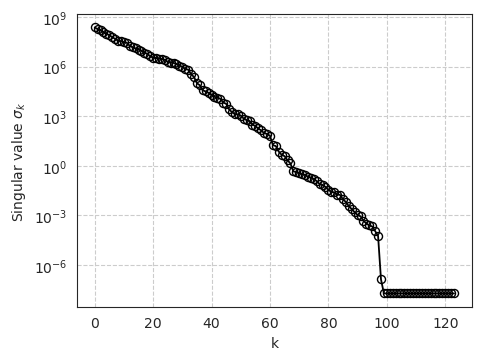

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

# this function returns the SVD computed singular values
singular_values = fit.get_singular_values()

# plot the singular values in a log scale
fig, ax = plt.subplots()
ax.plot(singular_values, color='k', lw=1.3, marker='o', fillstyle='none', markersize=5.8)
ax.set_yscale('log')
ax.set_xlabel('k')
ax.set_ylabel(r'Singular value $\sigma_k$')
ax.grid(which='major', linestyle='dashed')
fig.set_size_inches((5.1, 3.8))

Possible systematic deviations in the results can be seen by plotting the residuals and thier distributions with labels on the isotopes, the e/f-levels or the states

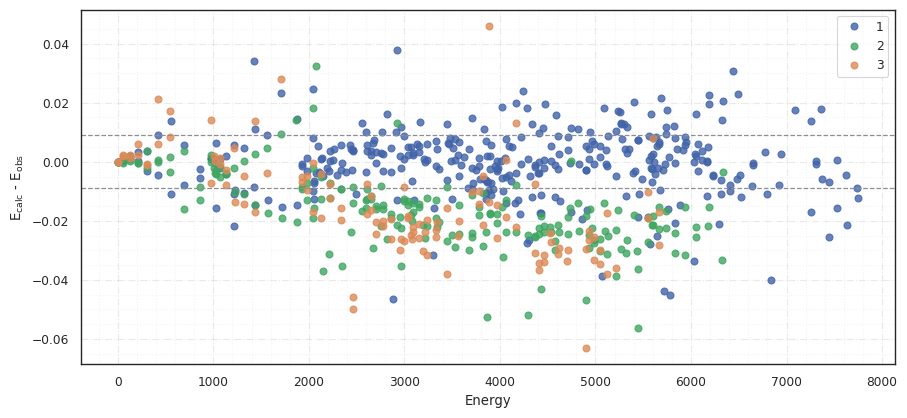

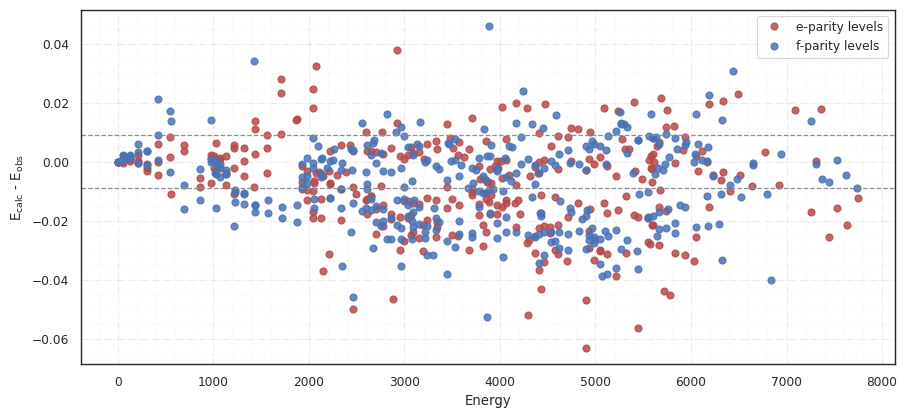

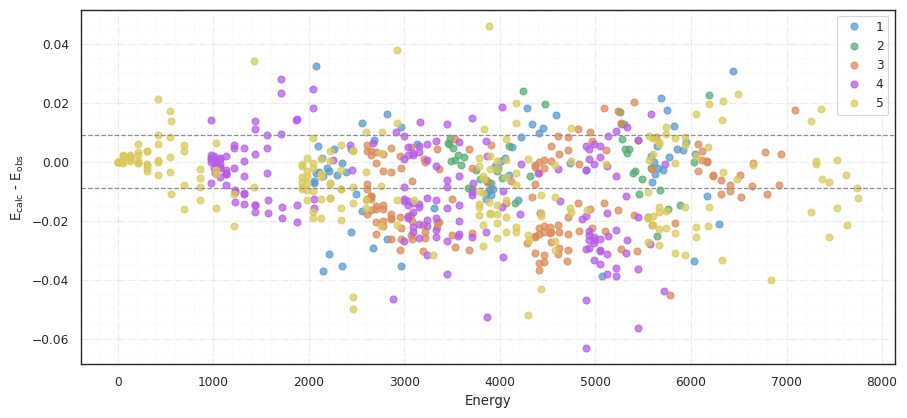

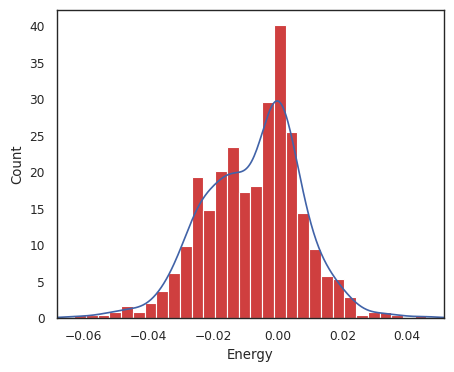

In [30]:
%matplotlib inline
Plotting.plot_residuals_by_isotopes(mlevels, save=False, size=(10.5, 4.6))
Plotting.plot_residuals_by_parity_labels(mlevels, save=False, size=(10.5, 4.6))
Plotting.plot_residuals_by_states(mlevels, save=False, size=(10.5, 4.6))
Plotting.plot_residuals_hist(mlevels, save=False, with_sns=False, size=(5,4))

Using the seaborn library both distributions can be plotted together:

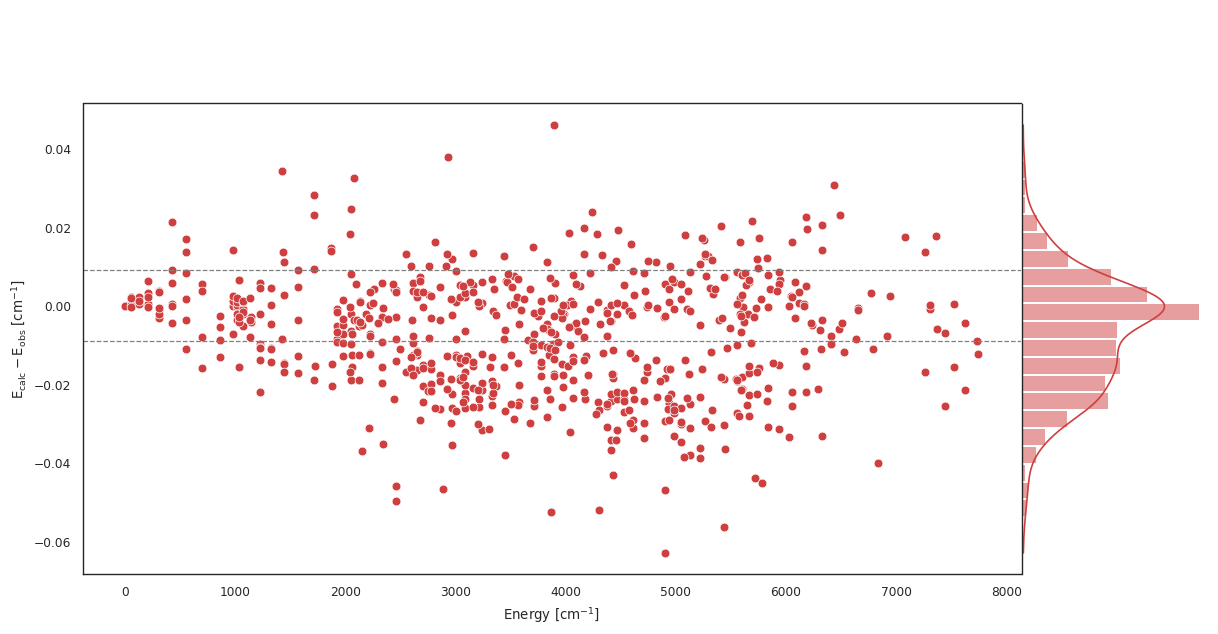

In [32]:
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set_context("paper")

# load the calculated energies
data = np.loadtxt('eigenvalues.dat')
x, y = data[:, 9], data[:, 10]

# create a joint plot
jgrid = sns.JointGrid(space=0.01)
sns.scatterplot(x=x, y=y, ax=jgrid.ax_joint, s=40)
sns.histplot(y=y, ax=jgrid.ax_marg_y, kde=True, lw=1.4)

jgrid.set_axis_labels(
    xlabel=r'Energy [$\mathrm{cm^{-1}}]$',
    ylabel=r'$\mathrm{E_{calc} - E_{obs}}$' + r' [$\mathrm{cm^{-1}}]$'
)

# annotate average uncertanty
average_uncert = np.sum(data[:, 11]) / x.shape[0]
jgrid.ax_joint.axhline(average_uncert, ls='--', lw=0.9, color='grey')
jgrid.ax_joint.axhline(-average_uncert, ls='--', lw=0.9, color='grey')

jgrid.fig.set_size_inches(12.5, 6.2)

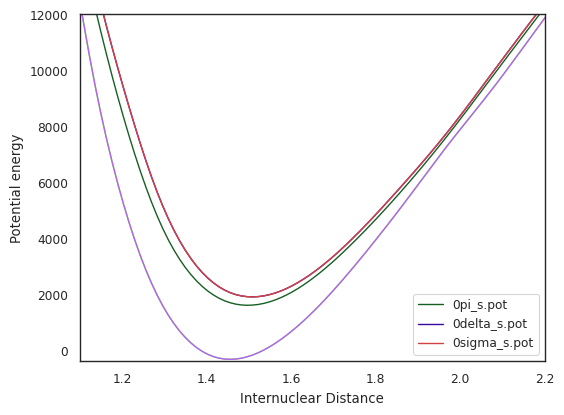

In [19]:
%matplotlib inline
Plotting.plot_potentials_on_grid(mlevels, xlim=(1.1,2.2), ylim=(-380,1.2e4), size=(6.0,4.5), save=False)

(None, None)

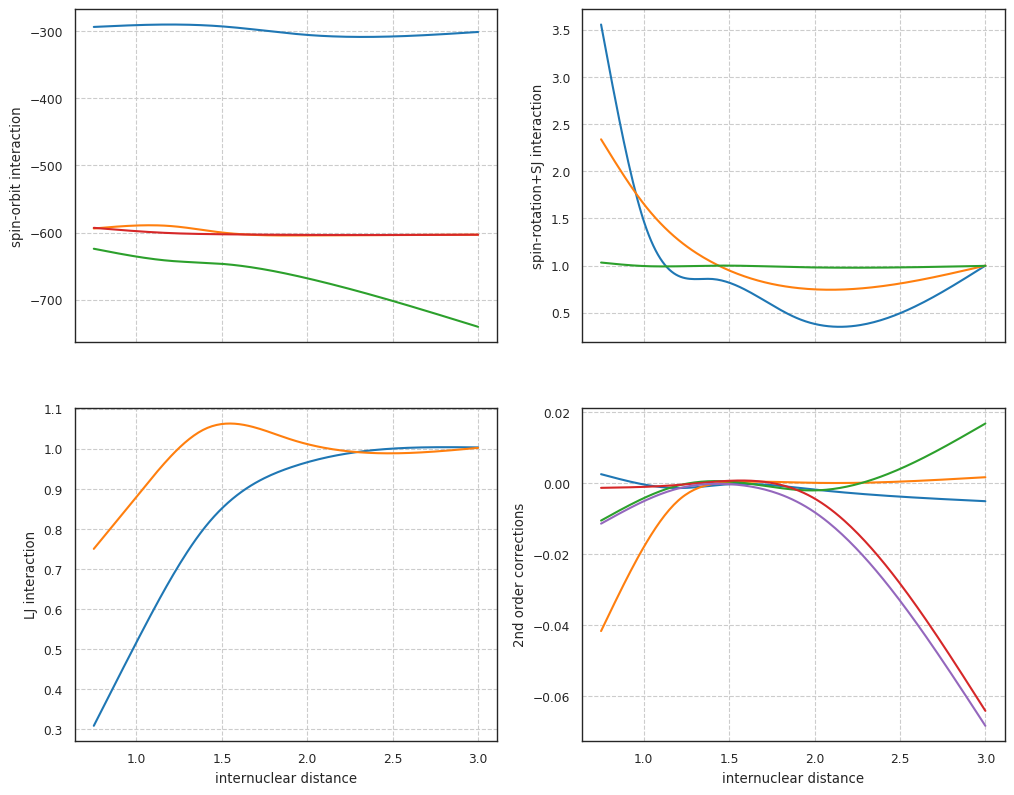

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from utils import C_hartree

fgrid = mlevels.get_couplings_on_grid()

fig, (ax1, ax2) = plt.subplots(2, 2, sharex=True, figsize=(12, 9.5))
colors = ['#CF3F3F', '#4163A8', '#3FA561', '#DC8A56', '#B65CE6']
plt.rc('axes', prop_cycle = cycler('color', colors))

for i in range(4):
    ax1[0].plot(rgrid, fgrid[:, i] * C_hartree, lw=1.5)
ax1[0].set_ylabel('spin-orbit interaction')

for i in range(4, 7):
    ax1[1].plot(rgrid, fgrid[:, i], lw=1.5)
ax1[1].set_ylabel('spin-rotation+SJ interaction')
    
for i in range(7, 9):
    ax2[0].plot(rgrid, fgrid[:, i], lw=1.5)
ax2[0].set_ylabel('LJ interaction')

for i in range(9, 14):
    ax2[1].plot(rgrid, fgrid[:, i] / C_hartree, lw=1.5)
ax2[1].set_ylabel('2nd order corrections')

xlabel = 'internuclear distance'
ax2[0].set_xlabel(xlabel), ax2[1].set_xlabel(xlabel)
ax1[0].grid(ls='--'), ax1[1].grid(ls='--')
ax2[0].grid(ls='--'), ax2[1].grid(ls='--')

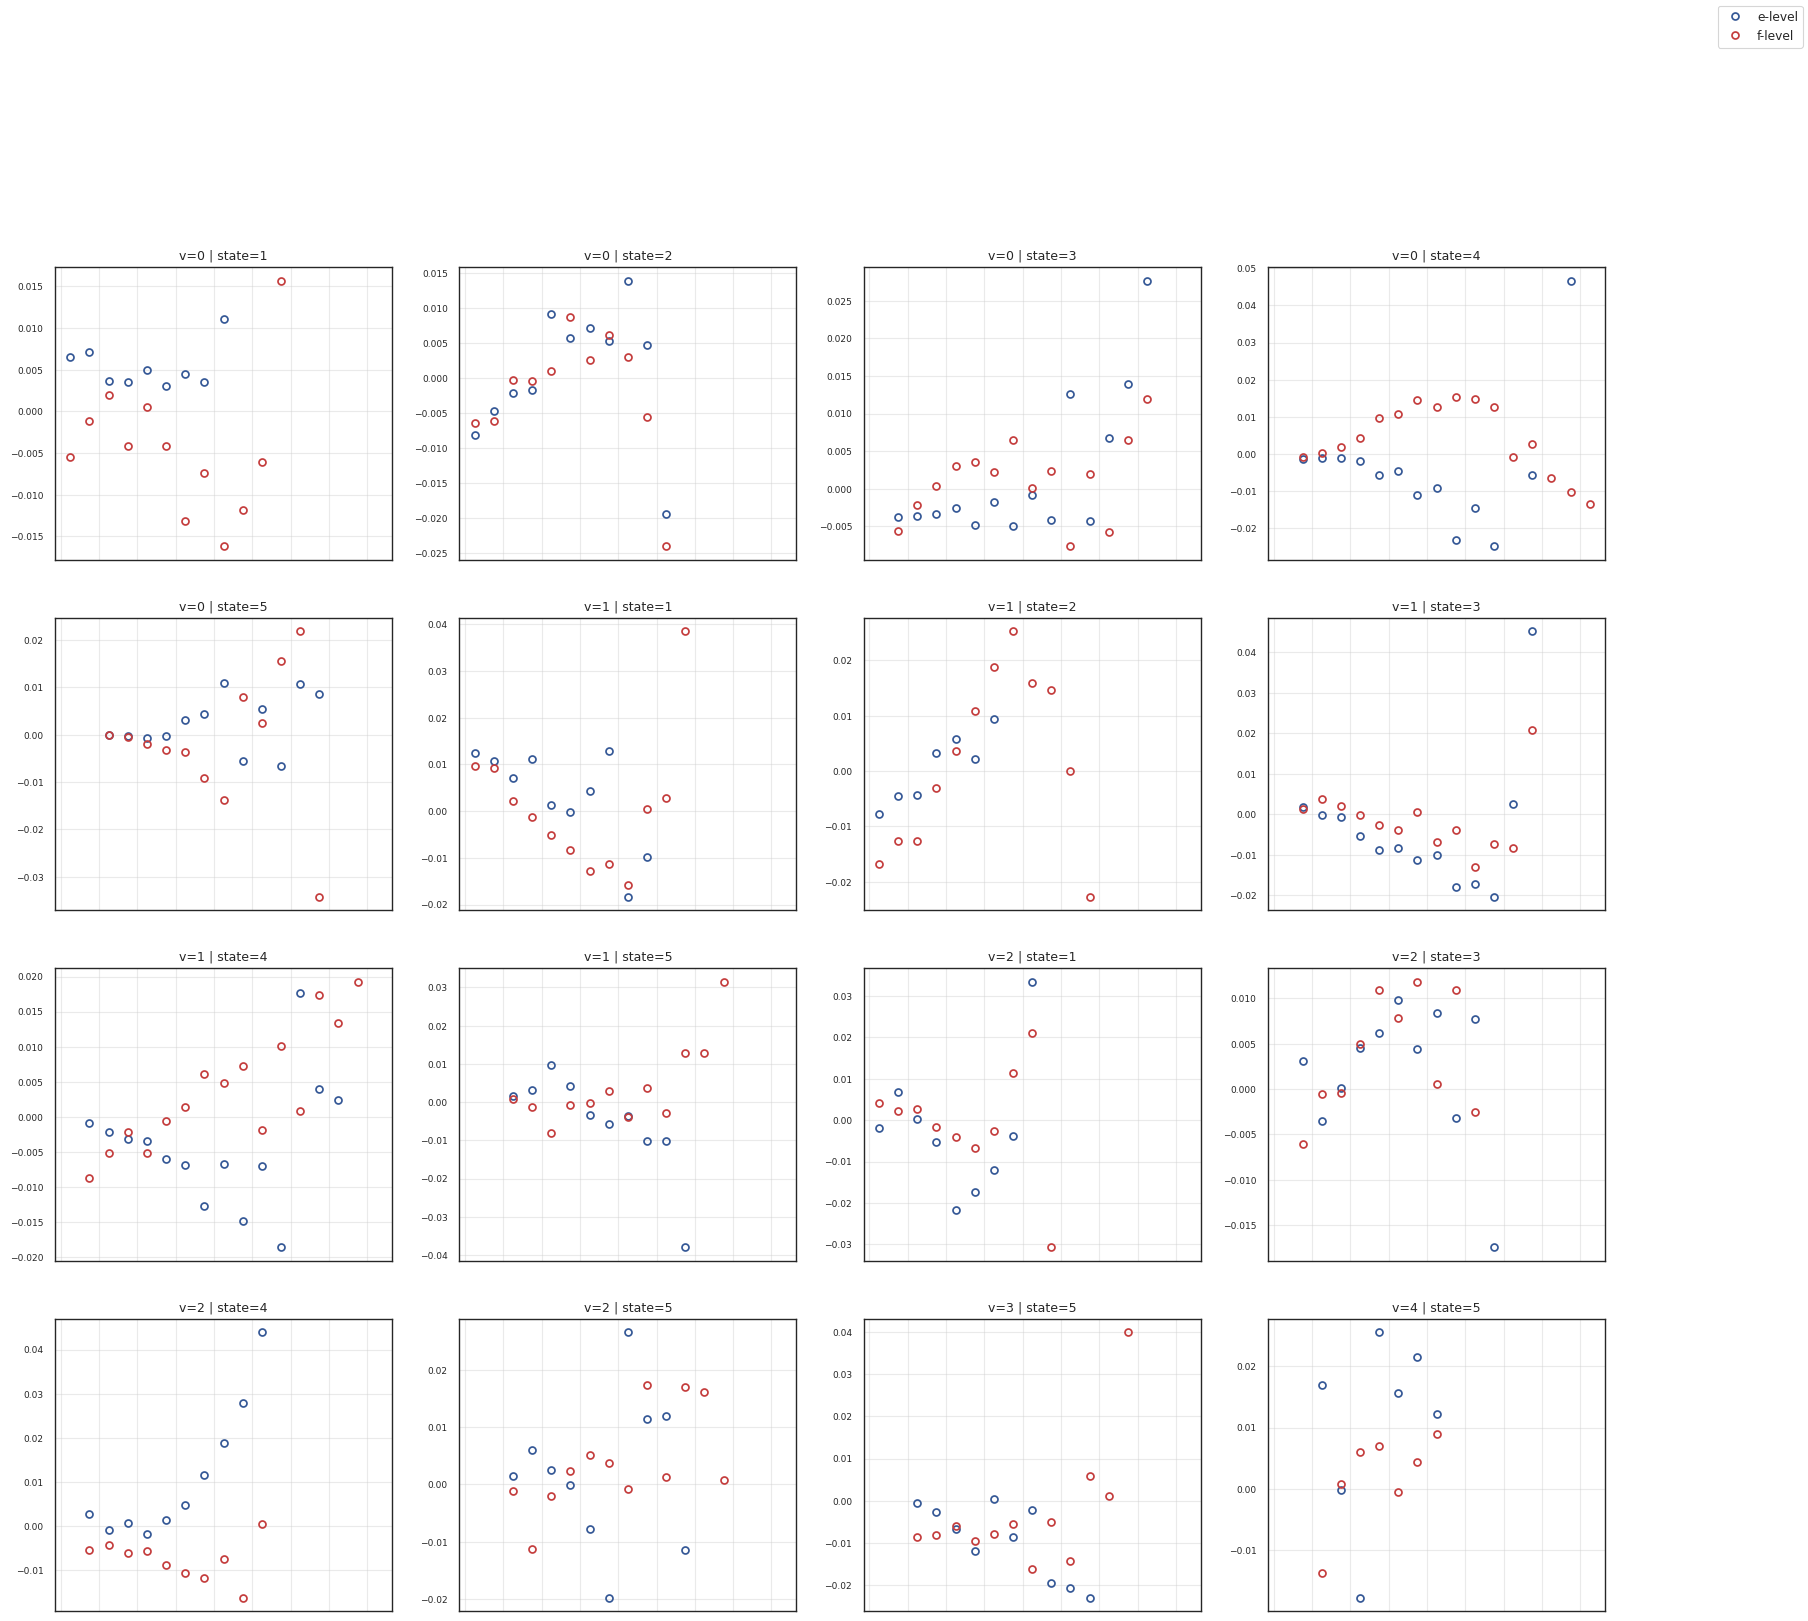

In [21]:
%matplotlib inline
Plotting.plot_residuals_level_subplots(mlevels, nrows=5, ncols=4, save=False, size=(20, 22))

In [22]:
#Plotting.hcolormesh(mlevels, save=False)

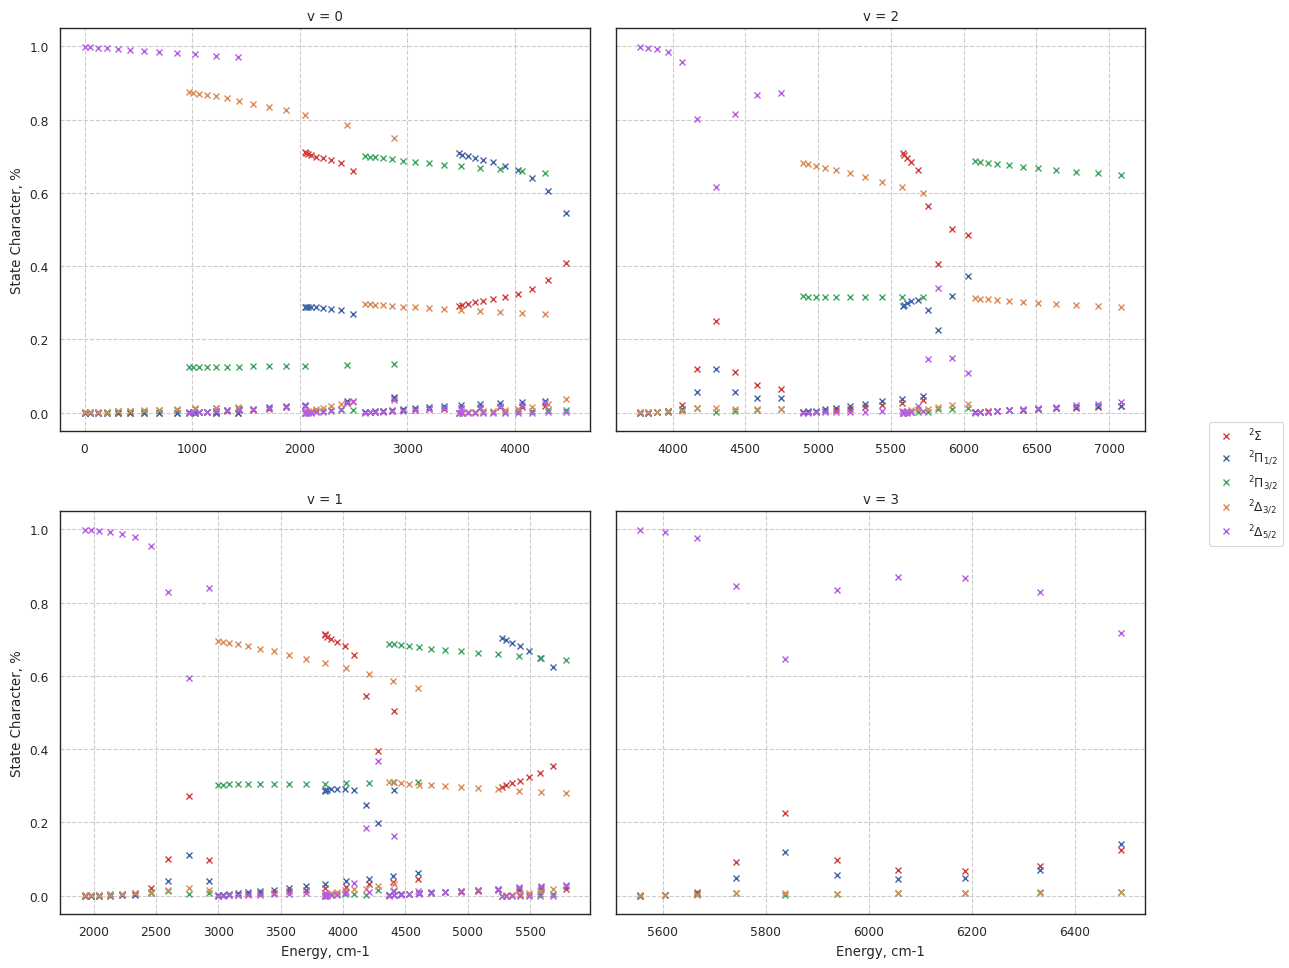

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_pair(v, pselected_data, ax):
    pos  = int(v / 2)
    vdata = pselected_data[pselected_data[:, 0] == v]
    x = vdata[:, 7]
    y1, y2, y3, y4, y5 = np.split(vdata[:, 11:16], 5, axis=1)
    pairs = x, y1, x, y2, x, y3, x, y4, x, y5
    ax[pos].plot(*pairs, lw=0, marker='x')
    ax[pos].grid(ls='--'), ax[pos].set_title(f'v = {int(v)}')

data = mlevels.get_output_data()
edata, fdata = data[data[:, 5] == 1], data[data[:, 5] == 0]
pselected_data = edata

# works only for even number of vibrational levels
vs = 4
fig, (ax1, ax2) = plt.subplots(math.ceil(vs/2), 2, sharey=True, figsize=(14, 11.5))
for v in range(0, vs-1, 2):
    plot_pair(v, pselected_data, ax1)
for v in range(1, vs, 2):
    plot_pair(v, pselected_data, ax2)

xlabel = 'Energy, cm-1'
ax2[0].set_xlabel(xlabel), ax2[1].set_xlabel(xlabel)
ylabel = 'State Character, %'
ax1[0].set_ylabel(ylabel), ax2[0].set_ylabel(ylabel)
fig.legend([r'$^2\Sigma$', r'$^2\Pi_{1/2}$', r'$^2\Pi_{3/2}$', r'$^2\Delta_{3/2}$', r'$^2\Delta_{5/2}$'], loc=5)
plt.subplots_adjust(wspace=0.05)